## TESS light curve fit for TOI562.1 (GJ357b)
Example of using some of the [lmfit](https://lmfit.github.io/lmfit-py/) Model classes in pycheops.models to fit the TESS light curve for a planet candidate orbiting an M-dwarf

In [20]:
%pylab inline
from astroquery.mast import Observations
from astropy.table import Table, Column
from pycheops import models
from pycheops.ld import stagger_power2_interpolator
from uncertainties import UFloat, ufloat
from emcee import EnsembleSampler
import celerite
from celerite import terms
from scipy.optimize import minimize
from astropy.time import Time
from pycheops.funcs import transit_width


Populating the interactive namespace from numpy and matplotlib


#### Target information
Taken from DVM Data summary report

In [21]:
TIC = 413248763 
T0 = 1517.9997  # Time of mid-transit, BJD-2457000
P = 3.93079     # Orbital period, days
k = 0.0333      # Rp/Rs, planet-star radius ratio
aR = 17.49       # a/Rs, semi-major axis/star radius 
b = 0.68        # Impact parameter

#### Limb darkening
Target star has T_eff = 3505K, log g=4.9 according to DVM.

Use the coefficients of the four-parameter limb-darkening law from Claret 2018, [J/A+A/618/A20/TESSa](http://vizier.u-strasbg.fr/viz-bin/VizieR-3?-source=J/A%2bA/618/A20/TESSa) for Teff=3500, logg=5.0, [M/H]=0 to calculate h_1 and h_2 parameters for power-2 limb-darkening.



h_1 = 0.820
h_2 = 0.485


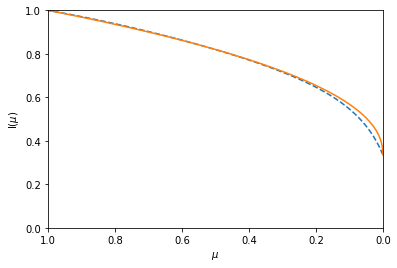

In [22]:
from pycheops.ld import ld_claret, ld_power2,h1h2_to_ca
a = [2.8284, -4.2140, 3.7248, -1.2529]
mu_Cri = 0.0392  
t = ld_claret(np.array([mu_Cri,0.5/(1-mu_Cri)]),a)
h_1 = t[1]
h_2 = t[1]-t[0]   
c2,a2 = h1h2_to_ca(h_1, h_2)
print('h_1 = {:0.3f}'.format(h_1))
print('h_2 = {:0.3f}'.format(h_2))
fig,ax  = subplots()
muC = linspace(mu_Cri,1,1000)
mu = linspace(0,1,1000)
ax.plot(mu,ld_claret(muC,a),ls='--')
ax.plot(mu,ld_power2(mu,[c2,a2]))
ax.set_xlim(1,0)
ax.set_ylim(0,1)
ax.set_xlabel(r"$\mu$")
ax.set_ylabel(r"I($\mu$)");


#### Download TESS data

In [23]:
flux_column = 'PDCSAP_FLUX'
# flux_column = 'SAP_FLUX'
#quality_bitmask=1130799  # "default": cadences with severe quality issues will be ignored
quality_bitmask=1664431 #  more conservative choice of flags to ignore - this is known to remove good data.

tjd = []
flux = []
import warnings
from astroquery.mast.core import NoResultsWarning
warnings.simplefilter('ignore',NoResultsWarning)
for obs in Observations.query_criteria(filters=["TESS"],target_name=TIC):
    obslist = Observations.get_product_list(obs['obsid'])
    m=Observations.download_products(obslist[obslist['description'] == "Light curves"])
    if m is not None:
        data = Table.read(m['Local Path'][0])
        iok = ( ((data['QUALITY'] & quality_bitmask) == 0) &
                isfinite(data['PDCSAP_FLUX'])).nonzero()
        data = data[iok]
        tjd=np.append(tjd,array(data['TIME']))  
        flx=data[flux_column] 
        flux=np.append(flux,flx/median(flx))


INFO: Found cached file ./mastDownload/TESS/tess2019032160000-s0008-0000000413248763-0136-s/tess2019032160000-s0008-0000000413248763-0136-s_lc.fits with expected size 1805760. [astroquery.query]


#### GP fit to flux between transits

We use Gaussian Process regression with [celerite](https://celerite.readthedocs.io/en/stable/) to model the flux variation between the eclipses.

The light-curve in binned into uniform time steps of 1 hour since we are only interested in modelling slow variations in flux.  

Transit width = 1.3 hrs
Initial log likelihood: 1766.195719963921


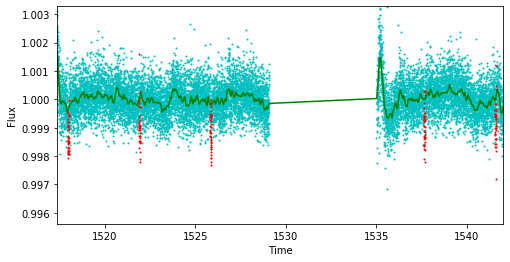

In [24]:
pwidth = transit_width(1/aR,k,b)
print('Transit width = {:0.1f} hrs'.format(pwidth*P*24))
phase = ((((tjd - (T0))/P % 1)+0.25) % 1) - 0.25
mask_out = (abs(phase) > pwidth/2).nonzero()
mask_in = (abs(phase) <= pwidth/2).nonzero()

tjd_mo = tjd[mask_out]
flux_mo = flux[mask_out]

n_bin = int(max(tjd)-min(tjd))*24
n_in_bin,bin_edges = np.histogram(tjd_mo,bins=n_bin)
bin_indices = np.digitize(tjd_mo,bin_edges)
t_bin = np.zeros(n_bin)
f_bin = np.zeros(n_bin)
e_bin = np.zeros(n_bin)
min_in_bin = 8
for i,n in enumerate(n_in_bin):
    if n > min_in_bin:
        t_bin[i] = mean(tjd_mo[bin_indices == i+1])
        f_bin[i] = median(flux_mo[bin_indices == i+1])
        e_bin[i] = 1.25*mean(abs(flux_mo[bin_indices == i+1] - f_bin[i]))/sqrt(n)

mask_not_empty = (e_bin > 0)
t_bin = t_bin[mask_not_empty]
f_bin = f_bin[mask_not_empty]
e_bin = e_bin[mask_not_empty]

Q = 1.0
w0 = 1.0
S0 = np.var(f_bin) / (w0 * Q)
bounds = dict(log_S0=(-25, 5), log_Q=(-15, 15), log_omega0=(-15, 25))
kernel = terms.SHOTerm(log_S0=np.log(S0), log_Q=np.log(Q), log_omega0=np.log(w0),
                        bounds=bounds)
bounds = dict(log_sigma=(-25, 5))
kernel += terms.JitterTerm(log_sigma=-5,bounds=bounds)
gp = celerite.GP(kernel, mean=1)
gp.compute(t_bin, yerr=e_bin)  # You always need to call compute once.
print("Initial log likelihood: {0}".format(gp.log_likelihood(f_bin)))
def neg_log_like(params, f_bin, gp):
    gp.set_parameter_vector(params)
    return -gp.log_likelihood(f_bin)

initial_params = gp.get_parameter_vector()
bounds = gp.get_parameter_bounds()
result_gp = minimize(neg_log_like, initial_params, method="L-BFGS-B", bounds=bounds, args=(f_bin, gp))
gp.set_parameter_vector(result_gp.x)
pred_mean = gp.predict(f_bin, tjd,return_cov=False,return_var=False)

fig1, ax1 = subplots(figsize=(8,4))
ax1.scatter(tjd_mo,flux_mo,s=1,c='c')
ax1.scatter(tjd[mask_in], flux[mask_in],s=1,c='r')
ax1.plot(tjd, pred_mean, color='g',ms=2)
ax1.set_xlim(min(tjd),max(tjd))
ax1.set_ylim(1-5*flux.std()-k**2,1+5*flux.std())
ax1.set_xlabel('Time')
ax1.set_ylabel('Flux')
flux_d = flux/pred_mean

#### Transit model

In [25]:
M = models.TransitModel()
pars = M.make_params()

pars.add('T_0', value = T0, min = round(T0-0.25*P,4),max=round(T0+0.25*P,4))
pars.add('P', value = P, min = 0.99*P,max = 1.01*P)
pars.add('D', value = k**2, min = 0.0001,max = 0.1)
pars.add('W', value = pwidth, min = round(pwidth/2,3),max = round(pwidth*2,3))
pars.add('b', value = b, min = 0,max = 1)
pars.add('f_c', value = 0, vary=False)  # Assume circular orbit
pars.add('f_s', value = 0, vary=False)  # Assume circular orbit
pars.add('h_1', value = round(h_1,3), vary=True)
pars.add('h_2', value = h_2, vary=False)
for p in pars:
    if pars[p].vary: print(pars[p])

<Parameter 'T_0', value=1517.9997, bounds=[1517.017:1518.9824]>
<Parameter 'P', value=3.93079, bounds=[3.8914821:3.9700979]>
<Parameter 'D', value=0.0011088900000000002, bounds=[0.0001:0.1]>
<Parameter 'W', value=0.014174928701777998, bounds=[0.007:0.028]>
<Parameter 'b', value=0.68, bounds=[0:1]>
<Parameter 'h_1', value=0.82, bounds=[-inf:inf]>


#### Plot initial fit

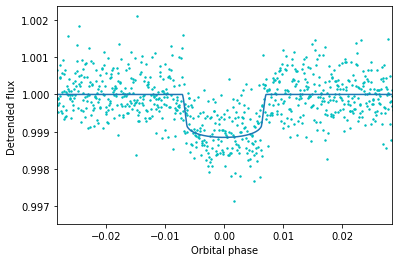

In [26]:
fig2, ax2 = subplots()
ph_plot = linspace(-2*pwidth,2*pwidth,1001)
t_plot = T0 + ph_plot*P
f_plot = M.eval(pars,t=t_plot)
ax2.scatter(phase,flux_d,s=2,c='c')
ax2.set_xlabel('Orbital phase')
ax2.plot(ph_plot,f_plot)
ax2.set_ylabel('Detrended flux ')
ax2.set_xlim(-2*pwidth,2*pwidth)
ax2.set_ylim(1-4*flux_d.std()-k**2,1+4*flux_d.std());

#### Least-squares fit
Initial values from fit to de-trended flux

In [27]:
result_lm = M.fit(flux_d,pars,t=tjd)
print(result_lm.fit_report())

[[Model]]
    Model(_transit_func)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 43
    # data points      = 13420
    # variables        = 6
    chi-square         = 0.00450009
    reduced chi-square = 3.3548e-07
    Akaike info crit   = -200055.489
    Bayesian info crit = -200010.462
[[Variables]]
    T_0:  1517.99946 +/- 3.0183e-04 (0.00%) (init = 1518)
    P:    3.93069183 +/- 1.3115e-04 (0.00%) (init = 3.93079)
    D:    0.00101788 +/- 1.0905e-04 (10.71%) (init = 0.00110889)
    W:    0.01380157 +/- 5.5206e-04 (4.00%) (init = 0.01417493)
    b:    0.55037497 +/- 0.52343125 (95.10%) (init = 0.68)
    f_c:  0 (fixed)
    f_s:  0 (fixed)
    h_1:  0.85326677 +/- 0.10692669 (12.53%) (init = 0.82)
    h_2:  0.4846392 (fixed)
    k:    0.03190428 +/- 0.00170896 (5.36%) == 'sqrt(D)'
    aR:   20.1314208 +/- 8.33863425 (41.42%) == 'sqrt((1+k)**2-b**2)/W/pi'
    rho:  7.08554199 +/- 4.7282e-04 (0.01%) == '0.013418*aR**3/P**2'
[[Correlations]] (unreported cor

#### Plot best fit

RMS = 579 ppm


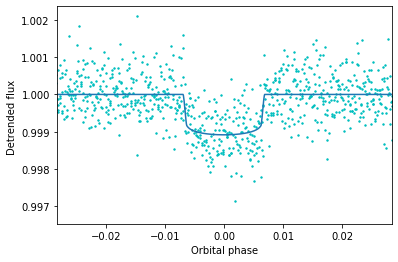

In [28]:
phase = ((((tjd - result_lm.params['T_0'])/result_lm.params['P'] % 1)+0.25) % 1) - 0.25
f_plot = M.eval(result_lm.params,t=t_plot)
resid = flux_d - M.eval(result_lm.params,t=tjd)
fig3, ax3 = subplots()
ax3.scatter(phase,flux_d,s=2,c='c')
ax3.set_xlabel('Orbital phase')
ax3.plot(ph_plot,f_plot)
ax3.set_ylabel('Detrended flux ')
ax3.set_xlim(-2*pwidth,2*pwidth)
ax3.set_ylim(1-4*flux_d.std()-k**2,1+4*flux_d.std());
print('RMS = {:0.0f} ppm'.format(1e6*resid.std()))

### Sampling the posterior with emcee 
 The user_data feature of lmfit's [Parameter](https://lmfit.github.io/lmfit-py/parameters.html#lmfit.parameter.Parameter) class can be used to set a ufloat values that defines a Gaussian prior on a parameter. 



In [29]:
nwalkers = 64
nburnin = 512
nsteps = 256
thin = 4

##### Prior probability distribution for D, W, b
This prior assumes uniform priors on $\cos i$, $\log k$ and $\log(a/R)$. The factor $2kW$ is the absolute value of the determinant of the Jacobian, $ J = d(D, W, b)/d(\cos i, k, a/R)$.

In [30]:
# Prior probability distribution for D, W, b
def _log_prior(D, W, b):
    if (D < 2e-6) or (D > 0.2): return -np.inf
    if (b < 0) or (b > 1): return -np.inf
    if (W < 1e-4): return -np.inf
    k = np.sqrt(D)
    aR = np.sqrt((1+k)**2 - b**2)/(np.pi*W)
    if (aR < 2): return -np.inf
    return -np.log(2*k*W) - np.log(k) - np.log(aR)

In [31]:
def log_posterior(pos, model, time, flux,  params, varnames, 
        return_fit):

    parcopy = params.copy()
    for i, p in enumerate(varnames):
        v = pos[i]
        if (v < parcopy[p].min) or (v > parcopy[p].max):
            return -np.inf
        parcopy[p].value = v
        
    fit = model.eval(parcopy, t=time)
    if return_fit:
        return fit
    if False in np.isfinite(fit):
        return -np.inf
    
    lnprior = _log_prior(parcopy['D'], parcopy['W'], parcopy['b'])
    if not np.isfinite(lnprior):
        return -np.inf
    
    # Also check parameter range here so we catch "derived" parameters
    # that are out of range.
    for p in parcopy:
        v = parcopy[p].value
        if (v < parcopy[p].min) or (v > parcopy[p].max):
            return -np.inf
        if np.isnan(v):
            return -np.inf
        u = parcopy[p].user_data
        if isinstance(u, UFloat):
            lnprior += -0.5*((u.n - v)/u.s)**2
            
    jitter = np.exp(parcopy['log_sigma'].value)
    s2 = jitter**2
    lnlike = -0.5*(np.sum((flux-fit)**2/s2 + np.log(2*np.pi*s2)))
    return lnlike + lnprior



In [32]:
params = result_lm.params.copy()
lnrms = np.log(resid.std())
params.add('log_sigma',value=lnrms,min=lnrms-5,max=lnrms+5)
vv = []
vs = []
vn = []
for p in params:
    if params[p].vary:
        vn.append(p)
        vv.append(params[p].value)
        if params[p].stderr is None:
            vs.append(0.01*(params[p].max-params[p].min))
        else:
            vs.append(params[p].stderr)           

init_scale = 0.1  # use this fraction of standard error to spread walker positions  
args=(M, tjd, flux_d,  params, vn, False)
pos = []
n_varys = len(vn)
for i in range(nwalkers):
    params_tmp = params.copy()
    lnlike_i = -np.inf
    while lnlike_i == -np.inf:
        pos_i = vv + vs*np.random.randn(n_varys)*init_scale
        lnlike_i = log_posterior(pos_i, *args)
    pos.append(pos_i)


#### Run the sampler

In [33]:
sampler = EnsembleSampler(nwalkers, n_varys, log_posterior,args=args)
print('Running burn-in ...')
pos, _, _ = sampler.run_mcmc(pos, nburnin, store=False, 
                             skip_initial_state_check=True, progress=True)
sampler.reset()
print('Running sampler ...')
state = sampler.run_mcmc(pos, nsteps, thin_by=thin, 
                         skip_initial_state_check=True, progress=True)

Running burn-in ...


100%|██████████| 512/512 [02:19<00:00,  3.67it/s]


Running sampler ...


100%|██████████| 1024/1024 [03:49<00:00,  4.45it/s]


#### Plot parameter v. step number to check for convergence

Only plotting selected parameters here.

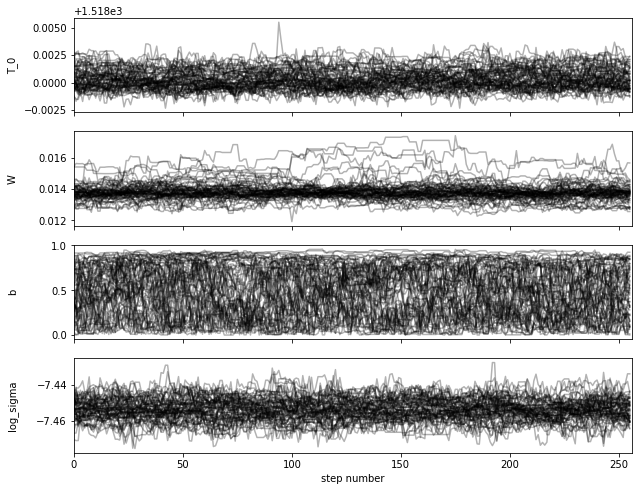

In [34]:
fig9, ax9 = plt.subplots(4, figsize=(10, 8), sharex=True)
samples = sampler.get_chain()
for i,p in enumerate(["T_0", "W", 'b', "log_sigma"]):
    ax = ax9[i]
    j = vn.index(p)
    ax.plot(samples[:, :, j], "k", alpha=0.3)
    ax.set_xlim(0, len(samples))
    ax.set_ylabel(p)
    ax.yaxis.set_label_coords(-0.1, 0.5)
ax9[-1].set_xlabel("step number");

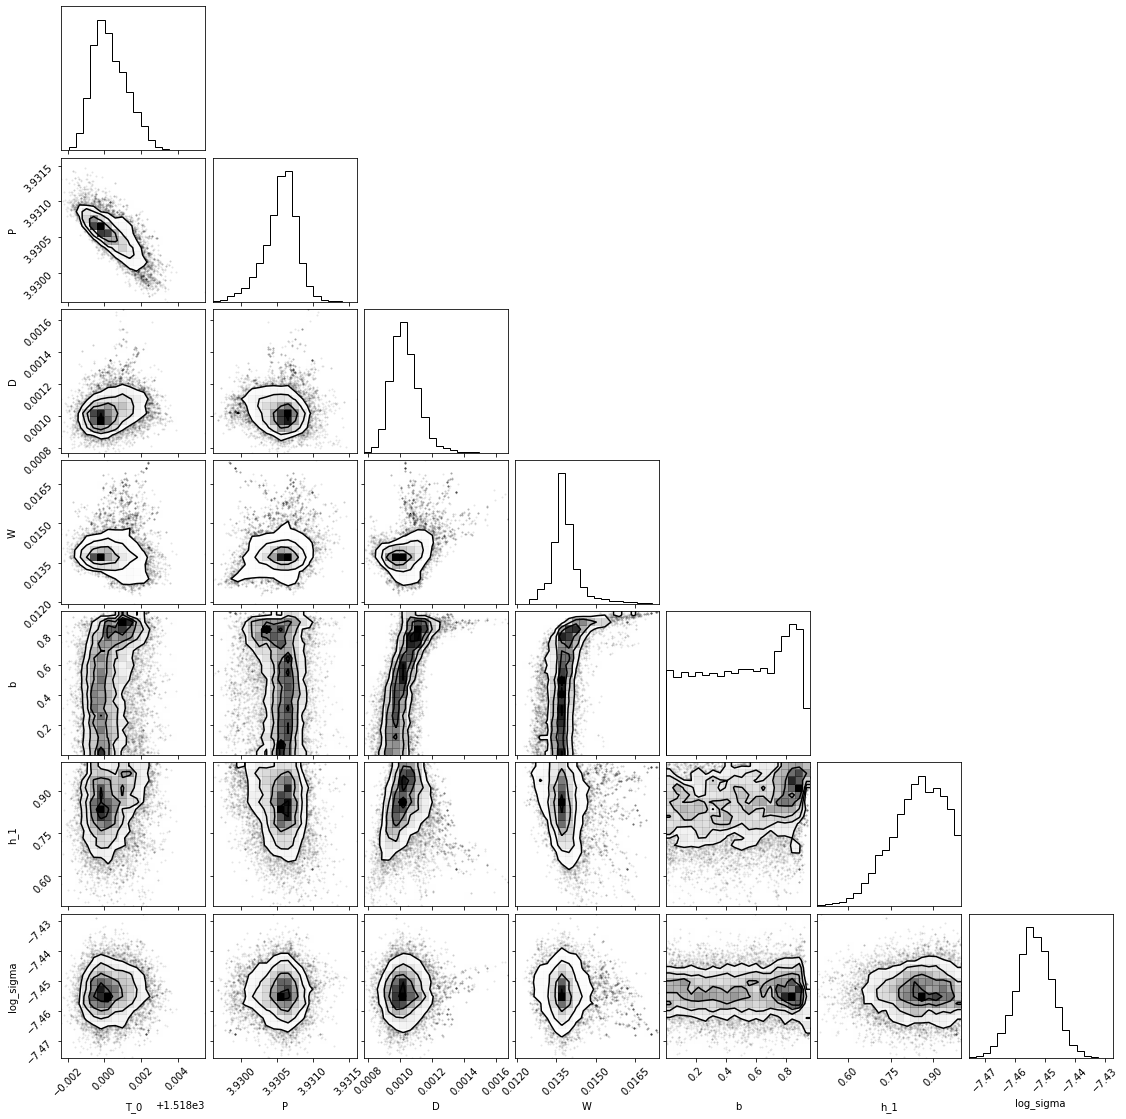

In [35]:
import corner
flat_samples = sampler.get_chain(flat=True)
fig = corner.corner(flat_samples, labels=vn);

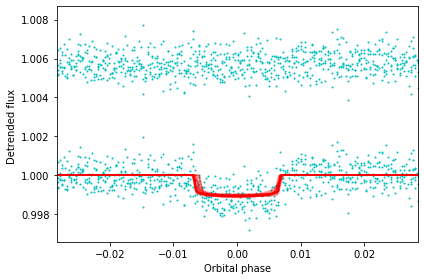

In [36]:
pos = flat_samples[argmax(sampler.flatlnprobability),:]
phase = ((((tjd - pos[vn.index('T_0')])/pos[vn.index('P')] % 1)+0.25) % 1) - 0.25
fit = log_posterior(pos, M, tjd, flux,  params, vn,
        return_fit=True)
rms = (flux_d-fit).std()

fig4, ax4 = subplots()
t_plot = pos[vn.index('T_0')] + ph_plot*pos[vn.index('P')]
f_plot = log_posterior(pos, M, t_plot, flux,  params, vn,
        return_fit=True)
ax4.scatter(phase,flux,s=1,c='c')
ax4.scatter(phase,flux-fit+1+10*rms,s=1,c='c')
ax4.set_xlabel('Orbital phase')
ax4.plot(ph_plot,f_plot,c='r')

nsamples = 64
for i in np.linspace(0,nsteps,nsamples,endpoint=False,dtype=np.int):
    pos = flat_samples[i,:]
    f_plot = log_posterior(pos, M, t_plot, flux,  params, vn,
        return_fit=True)
    ax4.plot(ph_plot,f_plot,c='r',alpha=0.1)

ax4.set_ylabel('Detrended flux ')
ax4.set_xlim(-2*pwidth,2*pwidth)
ax4.set_ylim(1-4*rms-k**2,1+15*rms);

fig4.tight_layout();


In [37]:
for i,n in enumerate(vn):
    print("{:4s} = {:0.5f} +/- {:0.5f}".format(n,flat_samples[:,i].mean(),flat_samples[:,i].std()))
print('RMS = {:0.0f} ppm'.format(1e6*rms))


T_0  = 1518.00033 +/- 0.00093
P    = 3.93055 +/- 0.00023
D    = 0.00103 +/- 0.00009
W    = 0.01385 +/- 0.00061
b    = 0.50160 +/- 0.27711
h_1  = 0.84340 +/- 0.09415
log_sigma = -7.45361 +/- 0.00609
RMS = 579 ppm


#### Observing window for future transits

In [38]:
Pmiss = 1  # Percentage probability to miss eclipse
obs_date = Time('2020-12-31T00:00:00')
cycle = round((obs_date.jd-2457000-T0)/P)
print('Cycle number = {:0.0f}'.format(cycle))
t = cycle*flat_samples[:,vn.index('P')] + flat_samples[:,vn.index('T_0')]
print('TJD mid-transit = {:0.5f} +/- {:0.5f}'.format(t.mean(),t.std()))
print('{}-% observing window = {:0.5f} - {:0.5f}'.format(100-Pmiss,*np.percentile(t,(Pmiss/2,100-Pmiss/2))))

Cycle number = 177
TJD mid-transit = 2213.70703 +/- 0.04035
99-% observing window = 2213.58548 - 2213.80839


#### Planet mass and radius
Stellar parameters and semi-amplitude of rv signal from Luque et al., [2019A&A...628A..39L](http://simbad.u-strasbg.fr/simbad/sim-ref?bibcode=2019A%26A...628A..39L)

- $M_{\star} =  0.342 \pm 0.011\,M_{\odot}$ Schweitzer et al. (2019)
- $R_{\star} =  0.337 \pm 0.015\,R_{\odot}$ Schweitzer et al. (2019)
- $K = 1.52 \pm 0.25$ m/s

    m_star   =      0.342 +/-      0.011 (    -0.011,    +0.011) R_Earth
    r_star   =      0.337 +/-      0.015 (    -0.015,    +0.015) R_Earth
    r_p      =      1.177 +/-      0.071 (    -0.069,    +0.073) R_Earth
    m_p      =       1.84 +/-       0.31 (     -0.30,     +0.31) M_Earth
    q        =  0.0000161 +/-  0.0000027 (-0.0000027,+0.0000027)
    a        =      7.330 +/-      0.078 (    -0.079,    +0.077) R_Sun
    a        =    0.03409 +/-    0.00036 (  -0.00037,  +0.00036) au
    rho_star =        7.9 +/-        4.6 (      -5.4,      +3.8) rho_Sun
    g_p      =       11.6 +/-        6.0 (      -6.7,      +5.3) m.s-2
    log g_p  =       3.06 +/-       0.27 (     -0.37,     +0.16) [cgs]
    rho_p    =       0.98 +/-       0.68 (     -0.71,     +0.65) rho_Earth
    rho_p    =        5.4 +/-        3.8 (      -3.9,      +3.6) [g.cm-3]


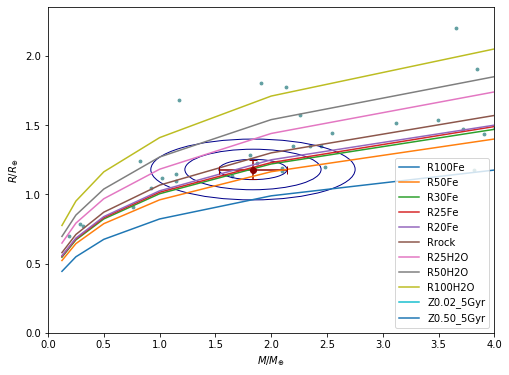

In [44]:
from pycheops.funcs import massradius, rhostar

k = np.sqrt(flat_samples[:,vn.index('D')])
b = flat_samples[:,vn.index('b')]
W = flat_samples[:,vn.index('W')]
aR = np.sqrt((1+k)**2-b**2)/W/np.pi
sini = np.sqrt(1 - (b/aR)**2)
rho_star = rhostar(1/aR,P)
massradius
m_star = (0.342, 0.011)
r_star = (0.337, 0.015)
res,fig =massradius(m_star=m_star, r_star=r_star, 
                    k=k, aR=aR, sini=sini, 
                    P=P, K=(1.52, 0.25),
                    zeng_models='all', xlim=(0,4))

&copy; Pierre Maxted, Keele University (2020)